Find outliers in white supremacist data to probably remove  
Outliers = posts that don't represent white supremacist ideology

# Topic modeling of white supremacist data

## LDA

In [2]:
# Load data
import pandas as pd

# path = '../tmp/white_supremacist_train_corpus.pkl'
path = '../tmp/white_supremacist_fulltext_train_corpus.pkl'
# path = '../data/corpora/full_text/white_supremacist_train_corpus.json'
# ws_data = pd.read_json(path, orient='table')
ws_data = pd.read_pickle(path)
ws_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3264772 entries, qian2018_0 to pruden2022_161
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   text        object             
 1   word_count  int64              
 2   dataset     object             
 3   source      object             
 4   domain      object             
 5   timestamp   datetime64[ns, UTC]
 6   num_words   int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 199.3+ MB


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(min_df=1, stop_words='english')
bow = vectorizer.fit_transform(ws_data.text)

In [5]:
# Save vectorizer
import pickle
# path = '../models/ws_forum_countvectorizer.pkl'
path = '../models/ws_fulltext_countvectorizer.pkl'
with open(path, 'wb') as f:
    pickle.dump(vectorizer, f)

In [6]:
lda = LatentDirichletAllocation(n_components=30, max_iter=10, n_jobs=-1, verbose=2)
lda.fit(bow)

# Save LDA
import pickle

# path = '../models/ws_forum_lda30.pkl'
path = '../models/ws_fulltext_lda30.pkl'
with open(path, 'wb') as f:
    pickle.dump(lda, f)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.6min remaining: 23.3min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.9min finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.8min remaining: 25.5min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.9min finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.0min remaining: 17.9min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.0min finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.2min remaining: 20.2min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.9min finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.6min remaining: 14.2min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.2min finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.5min remaining: 13.8min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.1min finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.9min remaining: 26.0min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  4.0min finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.7min remaining: 15.4min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.6min finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.7min remaining: 24.6min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.4min finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.7min remaining: 15.5min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  3.1min finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.8min remaining: 16.3min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.2min finished


In [7]:
doc_topics = lda.transform(bow)
doc_topics.shape

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  1.8min remaining: 15.8min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.9min finished


(3264772, 30)

In [54]:
# Print top words/topic
from IPython.display import display
pd.set_option('display.max_colwidth', None)

def top_words(model, feature_names, n_top_words):
    topic_lines = []
    for topic_idx, topic in enumerate(model.components_):
        topic_lines.append({'topic': str(topic_idx),
                            'top_words': " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])})
    return pd.DataFrame(topic_lines)
    
feature_names = vectorizer.get_feature_names()
topics = top_words(lda, feature_names, 10)
topics

# Count topic prevalence
# Assign documents to their highest topic
import numpy as np
import pandas as pd

def count_topic_documents(topic_docs):
    assigned_topics = np.argmax(topic_docs, axis=1)
    return pd.Series(assigned_topics).value_counts()

topics['document_count'] = count_topic_documents(doc_topics)
display(topics.sort_values('document_count', ascending=False))

def top_topic_documents(doc_topics, documents, n_docs):
    doc_ids = np.argsort(doc_topics, axis=0)[::-1][:n_docs]
    return {topic_id: [documents[doc_id] for doc_id in doc_ids[:, topic_id]] for topic_id in range(doc_ids.shape[1])}

top_topic_docs = top_topic_documents(doc_topics, ws_data.text, 20)

/home/mamille3/white_supremacist_lang/conda_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,topic,top_words,document_count
24,24,people just think quote know like posted originally say time,288614
1,1,fucking shit fuck nigger just faggot like kike literally retarded,226147
28,28,right people just jews like media left believe think jew,222464
9,9,women white men like woman man just black girl know,182220
27,27,white people whites race like black america country africa non,172818
20,20,like just food time good day eat know make water,172611
22,22,good got ve na just pretty ll yeah gon nice,157223
3,3,like post just video youtube looks look did music know,155030
17,17,pol thread just meme threads board shill posting post shills,154622
16,16,people children life society family need work child like world,149604


In [25]:
# Load, visualize annotations
path = '../data/white_supremacist_annotations_30topics.csv'
annotations = pd.read_csv(path)
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       600 non-null    object
 1   topic    600 non-null    int64 
 2   dataset  600 non-null    object
 3   text     600 non-null    object
 4   ws       600 non-null    int64 
 5   Notes    18 non-null     object
dtypes: int64(2), object(4)
memory usage: 28.2+ KB


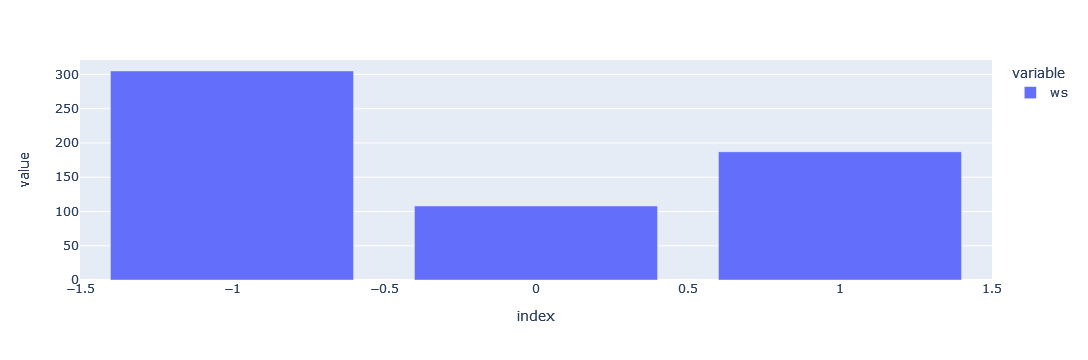

In [27]:
import plotly.express as px
pd.options.plotting.backend = 'plotly'

annotations.ws.value_counts().plot.bar()

In [28]:
annotations.ws.mean()

-0.19666666666666666

In [29]:
annotations.ws.std()

0.8846618562415279

In [41]:
means = annotations.groupby('topic').agg({'ws': ['mean', 'std']}).reset_index()
means.columns = ['topic', 'mean', 'std']
means

,topic,mean,std
0,0,0.45,0.887041
1,1,0.05,0.887041
2,2,0.05,0.887041
3,3,-0.70,0.732695
4,4,-0.20,1.005249
5,5,-0.10,0.852242
6,6,-0.15,0.988087
7,7,-0.10,0.911910
8,8,-0.30,0.864505
9,9,0.15,0.812728


In [45]:
means['topic'] = means.topic.astype('str')

In [46]:
means.sort_values('mean', ascending=False)

,topic,mean,std
27,27,0.65,0.587143
0,0,0.45,0.887041
13,13,0.35,0.875094
29,29,0.30,0.801315
9,9,0.15,0.812728
1,1,0.05,0.887041
2,2,0.05,0.887041
25,25,0.05,0.887041
10,10,0.00,0.858395
7,7,-0.10,0.911910


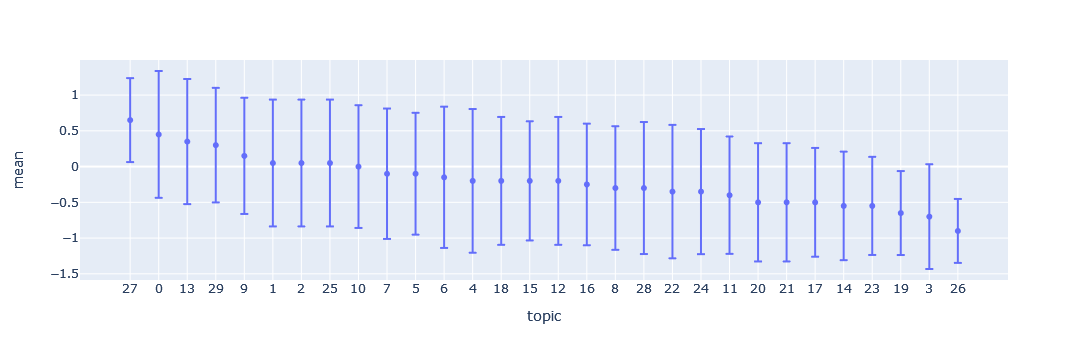

In [47]:
px.scatter(means.sort_values('mean', ascending=False), x='topic', y='mean', error_y='std')

In [50]:
topics['topic'] = topics.index.astype('str')
topics

,top_words,document_count,topic
topic,,,
0,jews jew jewish iq average dna genetic israel european jesus,53144,0
1,fucking shit fuck nigger just faggot like kike literally retarded,226147,1
2,flag eyes god hair blue red light brown dark earth,43826,2
3,like post just video youtube looks look did music know,155030,3
4,team niggers mini la peep gt ha heil da en,13015,4
5,national party socialism fascism fascist socialist communism political state capitalism,66624,5
6,10 million 11 000 12 20 15 percent 13 18,26616,6
7,god christian christianity religion church world history man christians greek,110639,7
8,jewish said anti mr court david new canada group law,66146,8


In [55]:
# Merge with topics
topic_anns = pd.merge(topics, means, on='topic')
topic_anns

,topic,top_words,document_count,mean,std
0,0,jews jew jewish iq average dna genetic israel european jesus,53144,0.45,0.887041
1,1,fucking shit fuck nigger just faggot like kike literally retarded,226147,0.05,0.887041
2,2,flag eyes god hair blue red light brown dark earth,43826,0.05,0.887041
3,3,like post just video youtube looks look did music know,155030,-0.70,0.732695
4,4,team niggers mini la peep gt ha heil da en,13015,-0.20,1.005249
5,5,national party socialism fascism fascist socialist communism political state capitalism,66624,-0.10,0.852242
6,6,10 million 11 000 12 20 15 percent 13 18,26616,-0.15,0.988087
7,7,god christian christianity religion church world history man christians greek,110639,-0.10,0.911910
8,8,jewish said anti mr court david new canada group law,66146,-0.30,0.864505
9,9,women white men like woman man just black girl know,182220,0.15,0.812728


In [57]:
topic_anns.sort_values('mean', ascending=False, inplace=True)

In [58]:
topic_anns

,topic,top_words,document_count,mean,std
27,27,white people whites race like black america country africa non,172818,0.65,0.587143
0,0,jews jew jewish iq average dna genetic israel european jesus,53144,0.45,0.887041
13,13,white race whites people blacks racial black non culture does,131057,0.35,0.875094
29,29,europe germany war jews world muslims russia countries country european,141997,0.30,0.801315
9,9,women white men like woman man just black girl know,182220,0.15,0.812728
1,1,fucking shit fuck nigger just faggot like kike literally retarded,226147,0.05,0.887041
2,2,flag eyes god hair blue red light brown dark earth,43826,0.05,0.887041
25,25,war military army states united state government soldiers forces did,69574,0.05,0.887041
10,10,want kill illegal job country work just free let live,104357,0.00,0.858395
7,7,god christian christianity religion church world history man christians greek,110639,-0.10,0.911910


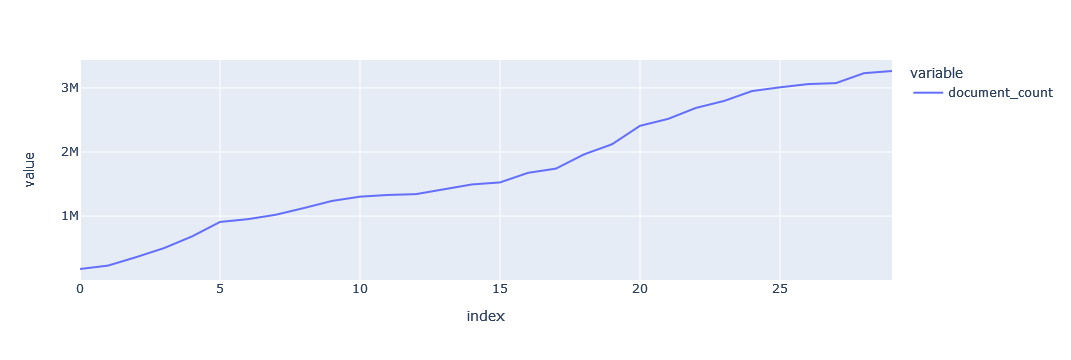

In [63]:
topic_anns.document_count.cumsum().reset_index().document_count.plot.line()

In [9]:
lda.n_batch_iter_

11

In [17]:
# Investigate topics

assigned_topics = np.argmax(doc_topics, axis=1)
ws_data['topic'] = assigned_topics
sample = ws_data.groupby('topic').sample(20)[['topic', 'dataset', 'text']]
sample

,topic,dataset,text
id,,,
papasavva2020_1886968,0,papasavva2020,"2000 years of history tossed out over 500 times . you 're a zionist hasbara abraham was the father of the arabs and the jews . i do n't care what jews or muslims say it 's their fight - they are brothers , they are both semites , they have the same dna they need to all go back to the middle east , their home ."
papasavva2020_2293445,0,papasavva2020,"the fuck are you talking about ? zagros mountain farmers were even more middle eastern genetically than modern day iranians , so that means that the guys you see in pictures are more white than the people that lived in iran in the past . 07/early-neolithic-genomes-from-eas tern.html they are no more white or were white than african americans ... just because you speak english or have inherited a slave owner 's haplogroup does n't mean you were white ."
jokubausaite2020_598547,0,jokubausaite2020,doing the jewish mimicry and calls himself hans-georg maaßen what is his real jewish name /pol ?
papasavva2020_995076,0,papasavva2020,"we 're all slaves to the jew , though , are n't we ?"
papasavva2020_1964667,0,papasavva2020,"no it 's not , fuck off kike . everything that opposes the jew is forbidden ."
papasavva2020_2646718,0,papasavva2020,go to the link this is not a prevelance study and was done through a period stretching several years
papasavva2020_1147713,0,papasavva2020,"well , either my test is bogus or i 'm just a bastard ... regardless , i 'm still white and 100 % european : ) )"
stormfront_25337,0,stormfront,oh and i forgot to add .. the money is from jews to jews while the greeks have to pay for it for eternity .. and to get that money the greeks have to sell off all their assets . so that a jew fatcat can sit around sunning his hairy arse in the acropolis since it will all be privatised which means sold off to jews . every single thing in greece must be sold off so they can get money to give to jews .
papasavva2020_2286081,0,papasavva2020,all of those are mixed mutts and a few smart doent negate how supid and uselles your average sandnigger is


In [20]:
sample.to_csv('../tmp/lda_sample20.csv')

In [14]:
pd.set_option('display.max_rows', None)
ws_data.groupby('topic')['domain'].value_counts()

topic  domain   
0      forum         52397
       tweet           434
       chat            165
       long-form       148
1      forum        224535
       tweet           995
       chat            584
       long-form        33
2      forum         42858
       tweet           491
       chat            360
       long-form       117
3      forum        151530
       tweet          2024
       chat           1191
       long-form       285
4      forum         12731
       tweet           212
       chat             39
       long-form        33
5      forum         64911
       tweet           949
       long-form       504
       chat            260
6      forum         24113
       tweet          1800
       long-form       592
       chat            111
7      forum        106364
       tweet          1979
       long-form      1932
       chat            364
8      forum         57354
       tweet          4664
       long-form      3745
       chat            383
9      foru

In [22]:
sample.dataset.value_counts()

papasavva2020       345
stormfront          118
jokubausaite2020     81
ironmarch            27
qian2018             18
patriotfront          4
pruden2022            4
calderon2021          3
Name: dataset, dtype: int64

In [21]:
# Investigate possibly off-topic topics
# selected_topics = [3,6,7,11] # for 20-topic model
# selected_topics = [15, 11, 14, 7, 25, 28, 10] # for sampled 30-topic model
# 15 remove, 11 keep, 14 remove, 7 remove, 25 remove, 28 keep
selected_topics = [27, 0, 3, 24, 7, 11, 1, 8, 2, 29, 23, 15, 16, 20, 5, 17]
# 27 keep (borderline), 0 remove (borderline), 3 remove (philosophizing, borderline), 24 remove,
# 7 remove (though has some identities), 11 remove (money, borderline), 1 remove (body/porn, borderline),
# 8 remove (children, has some family ws stuff), 2 keep (crime, borderline), 29 remove (video, youtube talk), 
# 23 remove (food), 15 remove (politics, borderline), 16 remove, 20 remove (short 4chan stuff like kek), 
# 5 remove (German, other langs), 17 remove (numbers, short)

def print_top_docs(topic):
    print(f'************* TOPIC {topic} *************************')
    print(topics.loc[topic, 'top_words'])
    print()
    print(f"------------------ TOP TOPIC {topic} DOCUMENTS ----------------------")
    print('\n\n'.join(top_topic_docs[topic]))
    print()
    
assigned_topics = np.argmax(doc_topics, axis=1)
docs = pd.DataFrame({'text': ws_data.text, 'topic': assigned_topics})

def assigned_docs_sample(topic):
    """ Sample docs that are assigned to a topic (that would be removed if remove that topic) """
    sample = docs[docs.topic == topic].sample(20).text.values.tolist()
    print(f"------------------ SAMPLE OF TOPIC {topic} DOCUMENTS ----------------------")
    print('\n\n'.join(sample)) 
    print()
    
for topic in selected_topics:
    print_top_docs(topic)
    assigned_docs_sample(topic)

************* TOPIC 27 *************************
just people think like know really does did say ve

------------------ TOP TOPIC 27 DOCUMENTS ----------------------
tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup tossup

is it possible to retract a given rep point .. if so how ? why would you want to do that ? you 're only repping ( yes , i know ... repping is n't really a word ) on a post by post basis . if you thought it was a good post and deserving of rep then there should n't be much of an issue , even if you do n't usually agree said member 's posts . i 've repped a few posts from a couple of members that i think for the most part are [ expletive ] -holes , jack- [ expletive 

In [23]:
to_remove = [0, 3, 24, 7, 11, 1, 8, 29, 23, 15, 16, 20, 5, 17]
will_remove = topics[topics.index.isin(to_remove)]['document_count'].sum()
will_remove

2231145

In [25]:
will_remove/len(ws_data)

0.46000182256917926

## BERTopic

### Train

In [15]:
# Load data
import pandas as pd

path = '../tmp/white_supremacist_train_corpus.pkl'
ws_data = pd.read_pickle(path)
ws_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229305 entries, calderon2021_0 to stormfront_99972
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   text        229305 non-null  object             
 1   word_count  229305 non-null  int64              
 2   dataset     229305 non-null  object             
 3   source      229305 non-null  object             
 4   domain      229305 non-null  object             
 5   timestamp   229051 non-null  datetime64[ns, UTC]
 6   num_words   229305 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 14.0+ MB


In [17]:
selected = ws_data[ws_data.domain=='forum']

In [18]:
# Remove stopwords
import nltk
from tqdm.notebook import tqdm

stops = nltk.corpus.stopwords.words('english') + ["n't"]
processed = [' '.join([wd for wd in x if not wd in stops]) for x in tqdm(selected.text.str.split())]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [52]:
from bertopic import BERTopic

topic_model = BERTopic(nr_topics=30)
topics, probs = topic_model.fit_transform(processed)
topic_model.get_topic_info()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,Topic,Count,Name
0,-1,81302,-1_people_like_would_white
1,0,1917,0_nigger_niggers_fucking_fuck
2,1,1449,1_white_whites_race_people
3,2,1130,2_israel_israeli_iran_syria
4,3,867,3_muslims_islam_muslim_islamic
5,4,761,4_socialism_communism_national_capitalism
6,5,723,5_die_und_der_ist
7,6,710,6_hitler_christianity_adolf_nazis
8,7,705,7_police_cops_prison_court
9,8,640,8_jesus_jews_god_christ


In [23]:
topic_model.save('../tmp/ws_forum_20topics.model')

### Load

In [3]:
from bertopic import BERTopic

topic_model = BERTopic.load('../tmp/ws_20topics.model')
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,195774,-1_people_white_would_nt
1,0,3454,0_amnesty_immigration_daca_noamnesty
2,1,3152,1_germany_refugees_german_die
3,2,2247,2_nigger_niggers_nt_fucking
4,3,2047,3_said_police_murder_death
5,4,1949,4_russia_putin_ukraine_russian
6,5,1904,5_vittu_uploaded_christianity_vimeo
7,6,1854,6_israel_iran_nuclear_israeli
8,7,1821,7_illegal_ice_illegals_aliens
9,8,1455,8_women_men_white_woman


### Explore

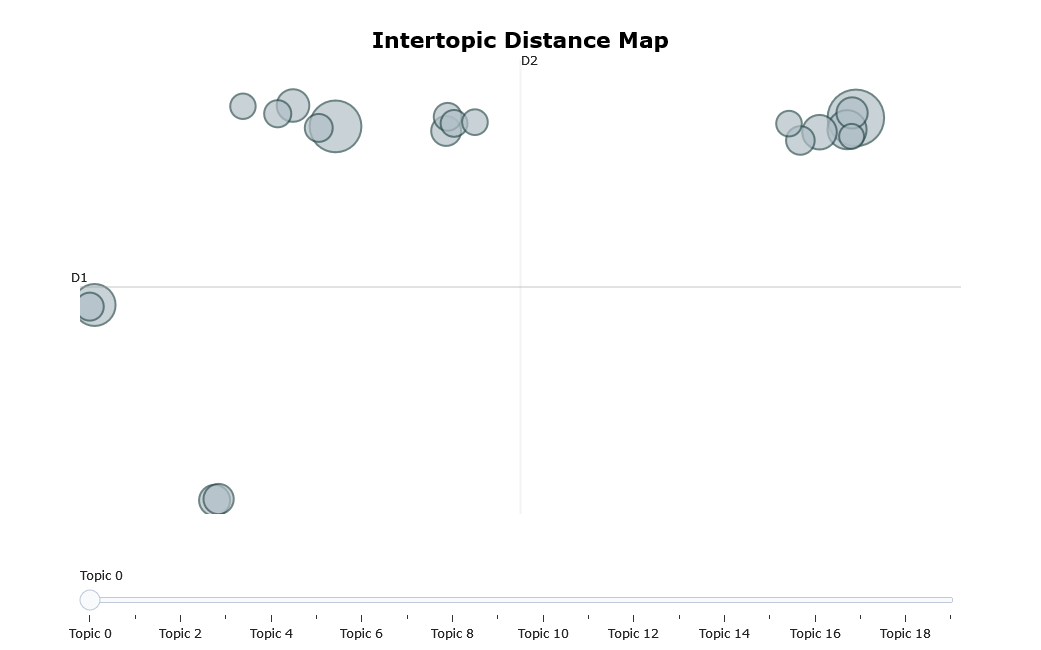

In [24]:
# Visualize topics
topic_model.visualize_topics()

In [28]:
# Look into particular topics that might be off-topic
from pprint import pprint
selected_topics = [8,9,10]

for topic in selected_topics:
    print(topic)
    pprint(topic_model.get_topic(topic))
    print('\n\n'.join(topic_model.get_representative_docs(topic)[:10]))
    print()

7
[('police', 0.057855429872677416),
 ('cops', 0.026430380685074514),
 ('court', 0.017742900761793454),
 ('prison', 0.017105304982540176),
 ('said', 0.01697966469426368),
 ('jail', 0.014509036892882191),
 ('charged', 0.013942757306675),
 ('cop', 0.013771395900569248),
 ('man', 0.013594467309457712),
 ('officer', 0.013550237139093325)]
good thing remember , whatever laws uphold , police generally decent individuals .

dislike police know useful . called cops multiple times past neighbors laud 10pm .

bets garrido murdered teens front sex-slave victim keep silent terrified . `` garrido investigation murder 15-year-old lisa norrell , found strangled november 1998 . body discovered nine days disappeared way home party antioch . '' think survivor dugard needs put suicide watch undoubtedly begin flashbacks . manuel , brentwood northern california , said : 'he fell bad crowd mexicans , started taking lsd , f * * * * * . went nuts . 's right head . little bastard know 's . garrido hung mexican

In [12]:
# Find original documents in specific topics
# Load white supremacist corpus (if need)
import pandas as pd

path = '../tmp/white_supremacist_train_corpus.pkl'
ws_data = pd.read_pickle(path)
ws_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229305 entries, calderon2021_0 to stormfront_99972
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   text        229305 non-null  object             
 1   word_count  229305 non-null  int64              
 2   dataset     229305 non-null  object             
 3   source      229305 non-null  object             
 4   domain      229305 non-null  object             
 5   timestamp   229051 non-null  datetime64[ns, UTC]
 6   num_words   229305 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 14.0+ MB


In [40]:
pd.set_option('display.max_colwidth', None)
search = 'activation email'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
stormfront_464865,"if you 've completed the registration form to become a member of this board using a valid email address , but you have n't received the automated activation email necessary to complete your registration , you can request manual activation here . first , however , make sure you 've checked any spam folders associated with your email account , since the board 's automated emails are sometimes misidentified as spam by overly aggressive filtering . yes ... i 'd like to request manual activation ... i have checked , rechecked and checked again and have'nt received the automated activation email .",102,stormfront,stormfront,forum,2008-07-14 13:22:00+00:00,102


In [41]:
search = 'contact tereasa'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
stormfront_297118,"the email address of wau missouri was hacked , so any information that was in [ email protected ] is now not in our control , so if anyone wants to contact tereasa please email her at [ email protected ] anyone who gets a message from anybody on msn using her name please do not repsond or give out information unless you have confirmed it is her via sf pm etc . we will be setting up secure emails for wau very soon . thanks wau",87,stormfront,stormfront,forum,2004-02-02 12:11:00+00:00,87


In [42]:
search = 'waited 12 hours'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
stormfront_465149,i waited 12 hours for email but received none . please fix and register me .,16,stormfront,stormfront,forum,2010-02-01 09:51:00+00:00,16


In [43]:
search = 'god dammit twitter'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
jokubausaite2020_655617,god dammit twitter why the fuck does your stupid video app spike cpu that hard,15,jokubausaite2020,4chan,forum,2016-07-08 23:26:05+00:00,15


In [51]:
search = 'around 50 posts'
ws_data[ws_data.text.str.contains(search)][['text', 'dataset']]

,text,dataset
id,,
stormfront_639008,"lol ! on a serious note it 's around 50 posts before you can send them without moderation - if you show that you 're really sensible , it may be less - be patient .... it 's worth the wait",stormfront


In [35]:
pd.set_option('display.max_colwidth', None)
search = 'mein mantel'
ws_data[ws_data.text.str.contains(search)]

text  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [39]:
pd.set_option('display.max_colwidth', None)
search = 'wir sind die braunen'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
papasavva2020_2684982,wir sind die braunen soldaten ( english & german lyrics ) : it 's outdated .,16,papasavva2020,4chan,forum,2019-04-20 18:03:53+00:00,16
papasavva2020_2822307,"wenn die ss und die sa aufmarschiert : m wenn die ss und die sa aufmarschiert ( english & german text ) : m der führer ruft sa voran ( english & german text ) : sa marschiert durch deutsches land : die braune kompanie ( english & german text ) : wir sind die braunen soldaten ( english & german text ) : brüder in zechen und gruben ( german text ) : volk ans gewehr : volk ans gewehr ( rare version ) : volk ans gewehr ( modern recording ) : volk ans gewehr ( english & german text ) : marsch über das lied volk ans gewehr : das volk steht auf , der sturm bricht los : als die goldne abendsonne ( rare version ) : als die goldne abendsonne ( rare version ) : als die goldne abendsonne ( very rare version ) : als die goldne abendsonne ( german text ) : m lied der eisernen division ( german text ) : deutscher kampf im lied ( rare version ) : deutscher kampf im lied ( rare version ) : hitlerleute : m am adolf hitler platz : am adolf hitler platz : m am adolf hitler platz : ein mann , ein wort : ein junges volk steht auf ( rare version ) : ein junges volk steht auf ( rare version ) ( english & german text ) :",238,papasavva2020,4chan,forum,2019-06-23 14:04:58+00:00,238


In [36]:
search = 'rot-rot'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
jokubausaite2020_287510,"results those are prognosis . 7 years , next government will be grün-rot-rot ( greens , commies , socdems ) , then after it fucked everything up with environmentalism , socialism , progressivism , left-wing liberalism and communism , afd will take over . mark my words .",48,jokubausaite2020,4chan,forum,2018-10-14 12:29:16+00:00,48
jokubausaite2020_4150,"aber rot-rot-grün an der macht würde policies in die welt setzen , die deutschland auf lange sicht in ein afrikanisches shithole verwandeln . die sind jetzt aber eh schon da . nun kannst du entscheiden ob wir dafür sorgen das mit euch das gleiche passiert .",46,jokubausaite2020,4chan,forum,2017-08-12 10:04:06+00:00,46


In [37]:
search = 'afd und 1 kreuz'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
jokubausaite2020_49047,komm gerade zurück . 2 kreuze für die afd und 1 kreuz für deutschland,14,jokubausaite2020,4chan,forum,2017-09-24 07:12:47+00:00,14


In [38]:
search = 'feindesland'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
calderon2021_14317,the lascowiec warcry # 2 nathanael lascowiec takes us on another tour of the white power and ns music scene around the world . this week including tunes by landser and phoenix . as usual there is a radio version with your host ’ s voice introducing the tunes and a music-only version available too . radio versiondownloadmusic only versiondownloadplaylistfinal war – aryan pride – 00:18 – 02:30hassgesang – wehr dich – 02:33 – 07:00nahkampf – legion condor – 07:10 – 10:31frontalkraft – my life for my land – 10:42 – 15:15nordfront – schlaflied 15:26 – 20:36molot – neizvestnye soldaty – 20:54 – 25:18honor – triumf nowej ery – 25:18 – 30:18phoenix – lebensraum – 30:35 – 34:46kiborg – sdelanno v rossii – 34:56 – 38:38division germania – morgen marschieren wir in feindesland – 38:49 – 41:20olaf jasinski and denis kolovrat – utrata very – 41:39 – 46:48landser – nordland – 46:57 – 49:52ogneslav – ya obyavlyayu voinu – 50:03 – 53:32,162,calderon2021,daily_stormer,long-form,2015-05-12 00:00:00+00:00,162
jokubausaite2020_183134,jugend und alter und mann für mann just like ss marschiert in feindesland there is only a right version and a kosher version .,24,jokubausaite2020,4chan,forum,2018-06-17 11:38:13+00:00,24
jokubausaite2020_363180,ss marschiert in feindesland fashwave - behemoth doom 2016 - the doom slayer,13,jokubausaite2020,4chan,forum,2019-03-15 21:25:44+00:00,13
papasavva2020_2285561,"es war ein edelweiss : es war ein edelweiss ( rare instrumental version ) : alte kameraden ( rare version ) : alte kameraden ( rare instrumental version ) : alte kameraden ( rare instrumental version ) : es ist so schön soldat zu sein : es ist so schön soldat zu sein ( rare version ) : es ist so schön soldat zu sein ( rare version ) : lore lore ( best version ) : lore lore ( rare version ) : lore lore ( rare version ) : lore lore ( very rare version ) : horst wessel lied ( rare version ) : horst wessel lied ( rare instrumental version ) : horst wessel lied ( very rare version ) horst wessel lied ( with english lyrics ) : horst wessel lied ( rare version ) : vorwärts vorwärts : vorwärts vorwärts ( with german lyrics ) : vorwärts vorwärts ( rare version ) : ss marschiert in feindesland : ss marschiert in feindesland ( very rare version ) : königgrätzer marsch : badenweiler marsch : badenweiler marsch : es pfeift von allen dächern ( very rare version ) : sieg heil mein deutsches vaterland : in sans souci , am mühlenberg : nskk lied : mit mercedes-benz voran : der mächtigste könig im luftrevier :",220,papasavva2020,4chan,forum,2018-10-14 04:28:28+00:00,220
papasavva2020_2322507,só se for agr espera acabar ss marschiert in feindesland,10,papasavva2020,4chan,forum,2018-10-28 21:26:02+00:00,10
papasavva2020_2322508,"ss marschiert in feindesland , co cops until now ...",10,papasavva2020,4chan,forum,2018-10-28 21:27:32+00:00,10
papasavva2020_2697998,lore lore ( best version ) : lore lore ( rare version ) : m lore lore ( rare version ) : lore lore ( very rare version ) : horst wessel lied ( rare version ) : horst wessel lied ( rare instrumental version ) : horst wessel lied ( rare version ) : horst wessel lied ( with english text ) : horst wessel lied ( very rare version ) horst wessel lied ( very rare version ) : m horst wessel lied ( very rare version ) : vorwärts vorwärts : vorwärts vorwärts : vorwärts vorwärts ( english & german lyrics ) : vorwärts vorwärts ( rare version ) : ss marschiert in feindesland : ss marschiert in feindesland ( very rare instrumental version ) : ss marschiert in feindesland ( english & german lyrics ) : m ss marschiert in feindesland ( with english text ) : ss marschiert in feindesland ( rare instrumental version ) : wenn die ss und die sa aufmarschiert : m wenn die ss und die sa aufmarschiert ( english & german lyrics ) : m marschlied der leibstandarte : m ss lied : m marsch der elisabether ( rare version ) : königgrätzer marsch : königgrätzer 

In [29]:
pd.set_option('display.max_colwidth', None)
search = '30.06 rifles'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
papasavva2020_983345,"been looking for that pic . thanks . i want to also add that semi-automatic 30.06 rifles , like the remington 750 , have been around since the 1940s in civilian hands . they have had 10-round and bigger clips since at least the '70s ; and are literally more likely to kill somebody because 30.06 is bigger than .556 .",61,papasavva2020,4chan,forum,2017-10-05 15:18:06+00:00,61


In [30]:
search = 'high quality semiauto'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
papasavva2020_1197087,"a high quality semiauto is actually better than most beat up rack grade military guns . i would take my personal mk12 copy over a beater m4a1 any day . i 'm not a rifle guy , but even i know this . plenty of `` hunting rifle '' semi 's would be more effective than a spray and pray m4 on full auto .",65,papasavva2020,4chan,forum,2017-11-15 06:57:33+00:00,65


In [32]:
search = 'make ccw unworkable'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
stormfront_142341,"school gun free zones make ccw unworkable the idea of a `` gun free zone '' around a school needs to be challenged as a direct infringement of the second amendment . here 's a map of cleveland and all the areas , you would have to avoid if you had a ccw permit .",55,stormfront,stormfront,forum,2012-12-17 23:52:00+00:00,55


In [34]:
search = 'leftiepol fucker'
ws_data[ws_data.text.str.contains(search)]

,text,word_count,dataset,source,domain,timestamp,num_words
id,,,,,,,
papasavva2020_3053596,"i 'd love to shred you with a gutting knife , leftiepol fucker .",14,papasavva2020,4chan,forum,2019-08-19 23:06:36+00:00,14
